Now that we are satisfied that our generated and markovified data produce normal results, let's concentrate on one subset and look for
specific data in that subset.

We would like to know, how many of our 'brake claims' are associated with 'brake pads' wearing down and needing replacement.  Typically, when brake
pads wear down, the pads themselves will come into contact with the brake drum.  This produces a grinding or screeching noise.  

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.4 MB 43.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 94.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 92.1 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 99.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.8 MB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 103.8 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 98.3 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 92.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 95.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 97.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 90.2 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 103.3 MB/s eta 0:00:01
     |████████████████████████████████| 456 kB 99.7 MB/s eta 0:00:01
     |██████████████████████

In [2]:
import pandas as pd

df = pd.read_csv('response.csv') 
df = df.fillna('')
df['response']=df.iloc[:,3]+df.iloc[:,5]+df.iloc[:,6]
df['issue'] = df.iloc[:,1]
df['symptom'] = df.iloc[:,2] + df.iloc[:,4]
subset = df.iloc[:,-3:]
subset

,response,issue,symptom
0,my brakes make a noise whenever I try to stop,Brakes,Car makes grinding noise
1,super frustrating every time I start my car it...,Starter,Car starts then stops
2,I can't open the damn door to my car,Other,
3,I turn the key and nothing happens,Starter,Car doesn't start
4,Car doesn't always start when it's low on blin...,Starter,Car doesn't start
...,...,...,...
104,my breaks are faulty.,Brakes,"Car brakes, but then brakes disengage"
105,my lights do not work,Other,
106,I try to start the engine only to find that th...,Starter,Car doesn't start
107,The driver side window auto function does not ...,Other,


In [3]:
import markovify
import codecs

In [4]:
#markovify is a simple, extensible Markov chain generator
#Its primary use is for building Markov models of large corpora of text and generating random sentences from that.


#builds the model according to what issue (e.g. brakes, starter, other) is given
def train_markov_type(data, issue):
    return markovify.Text(data[data["issue"] == issue].response, retain_original=False, state_size=2)

#takes one of the 'issue' models and creates a randomly-generated sentence of length up to 200 characters.  Note only creates '1' sentence
def make_sentence(model, length=100):
    return model.make_short_sentence(length, max_overlap_ratio = .7, max_overlap_total=15)

other_model = train_markov_type(subset, "Other")
brakes_model = train_markov_type(subset, "Brakes")
starter_model = train_markov_type(subset, "Starter")

In [5]:
make_sentence(other_model)  #creates a sentence that should be an example of 'other' issue(category)

"There isn't an immediate response."

In [6]:
make_sentence(brakes_model)  #creates a sentence that should be an example of 'brakes' issue(category)

'My cars breaks make a terrible sound when breaking.'

In [7]:
make_sentence(starter_model)   #creates a sentence that should be an example of 'starter' issue(category)

'It makes a grinding noise too.'

We can combine these models with relative weights

In [8]:
#create a compound model in which the sentences that come out will be 2x as many 'other' than 'brakes' or 'starters'

compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

In [9]:
#make 20 sentences out of the compound model - copy the text into a spreadsheet and check the count of the issues  (e.g. how many brake issue are there?)

for i in range(28):
    print(make_sentence(compound_model))

The steering wheel shakes when running at speed
I tried starting my car does not turn over
I have a problem with my blinker fluid.
The left rear window only rolls down but does not roll back up.
When I hit the start button to turn everything off, everything stays on.
It takes a long time before finally engaging and actually turning on.
It won't start again.
There is a light or stop sign and then nothing happens.
The air conditioner only blows cold sometimes.
It makes a lot noise and feeling a vibration when I press down on the left door is scratched.
the privacy glass between my driver and my tires seem to be working.
When turning, the car is making a clicking sound but would not start.
While driving I hear lot of black smoke and acrid smell.
https://www.youtube.com/watch?v=bEME9licodY
It's not actually a grinding noise, more like a piercing shriek of anguish
The oil change light comes on after an oil change has been performed.
Steering wheel shakes when running at speed
I think my car

In [10]:
import numpy
def generate_cases(models, weights=None):
    if weights is None:
        weights = [1] * len(models)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]


    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    
    while True:
        yield (make_sentence(choose_model()))
            

In [11]:
#compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

t = generate_cases([other_model, brakes_model, starter_model], [3,4,4])  #actual sentences



In [12]:
[next(t) for i in range(100)]  #create 100 sentences

['The car make some screeching or grinding noises when stopping.',
 'Dashboard computer reboots when traveling above 80mph',
 'Then I have to stretch my leg to do it.',
 'If I pump the brake pedal',
 'I can hear the starter with a hammer.',
 'I try to start the engine unless you hit the starter with a hammer.',
 'Have to cycle the ignition button at least twice before my car it just stops again, what is wrong!',
 'Car creates whistle sound each time I try to start it.',
 "I can't drive that way, always these bullshitty new technologies...",
 'It is more squealing or screeching sounds than grinding.',
 'Maybe the brakes of my car.',
 'The HVAC system is broken in the back of the car.',
 'My car does not turn over',
 "It won't start the engine doesn’t power up",
 "That's all good.",
 'It is very unpleasant.',
 'My car is leaning on left',
 "Car doesn't always start when it's low on blinker fluid",
 'brake pads are not wearing down evenly',
 "I can't get up to 88 MPH",
 'Car creates whist

Checking for similarity (slow)

In [ ]:
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#in your terminal window, execute the following code, before loading 'en_core_web_sm':
#     cd vehicle-claims-processing/
#     python -m spacy download en_core_web_sm


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, 

Mean similarity: 0.7924319540065342
[0.9078390543076835, 0.4845971121994884, 0.753279249675599, 0.9025749334899409, 0.739735949044245, 0.7284779587911665, 0.7561121363235664, 0.6277181723330252, 0.5677476852512697, 1.0, 0.7903552909353343, 1.0, 1.0, 0.7776286222795109, 0.6701604401467355, 0.9078390543076835, 0.7338118590491861, 1.0, 0.7279971917605249, 0.6757561202875948, 0.5677476852512697, 0.7638018181247417, 0.6922737382568802, 0.7800135107690807, 0.7010319355008847, 0.846070743212474, 0.6272582659167225, 0.8629527504418706, 0.6955667974732457, 0.7291098415833142, 1.0, 0.7131887376648282, 0.7142442828648483, 0.5571128736040991, 0.7973950889419062, 0.7181275284009544, 0.6972655969588063, 1.0, 0.8235915877023573, 0.8777137627959019, 0.85913011650759, 0.7269854599294534, 0.876784986485434, 1.0, 0.8395184322916649, 0.8318749482532465, 0.7880386225136826, 0.8582089136207721, 1.0, 1.0, 0.7615527000494979, 0.6277181723330252, 0.7716397987942751, 0.6984839388660253, 0.8628877537966684, 0.55

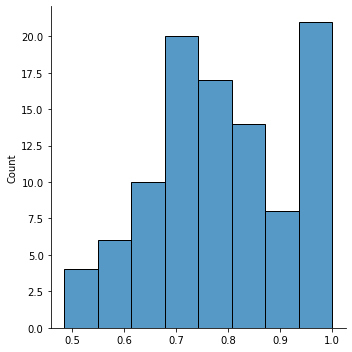

In [13]:
import spacy

#spacy is a free industrial-strenth NLP in python (https://spacy.io/)
#en_core_web_sm is an english pipeline optimized for cpu.  components: tok2vec, tagger, prser, senter, ner, attribure_rulter, lemmantizer

nlp = spacy.load('en_core_web_sm')  #the nlp is going to tokenize the lists dt_b, dt_a
#nlp = spacy.load('en')

dt_b = subset["response"]  #109 responses (from our google form) in our response.csv
dt_a = [next(t) for i in range(100)]  #created sentences from 3 models that were combined.  Remember the 3 models were (created) based on the the reponse.csv issues (categories)

import numpy as np
a = []
for sentence in dt_a:
    doc = nlp(sentence)
    m = 0
    for sentence1 in dt_b:
        doc1 = nlp(sentence1)
        if m < doc.similarity(doc1):
            m = doc.similarity(doc1)  #m is taking the highest similarity of all the comparisons made  (a[] is a bunch of numbers between 1 and -1)
    a.append(m)
        
print("Mean similarity: " + str(np.array(a).mean()))
print(a)

import seaborn as sns
sns.displot(a)

#plotting generated sentences vs google form sentences.  For each google form sentence, what was the most similiar in the list of generated sentences.
#have a fairly normal distributation which demonstrates that our nlp generation isn't bad :)

In [14]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [15]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

Fri Mar 26 15:58:17 2021    generatestats

         325196 function calls (298092 primitive calls) in 0.179 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.002    0.000    0.009    0.000 <ipython-input-10-5f1382f3447f>:13(choose_model)
     2000    0.002    0.000    0.177    0.000 <ipython-input-10-5f1382f3447f>:2(generate_cases)
        1    0.001    0.001    0.179    0.179 <ipython-input-14-801ca619797e>:3(timing)
     2000    0.002    0.000    0.166    0.000 <ipython-input-4-c0cb6e445263>:10(make_sentence)
        1    0.000    0.000    0.179    0.179 <string>:1(<module>)
    68516    0.019    0.000    0.028    0.000 chain.py:10(accumulate)
    29394    0.022    0.000    0.140    0.000 chain.py:112(gen)
     2290    0.006    0.000    0.146    0.000 chain.py:125(walk)
    29394    0.075    0.000    0.118    0.000 chain.py:96(move)
     2290    0.001    0.000    0.002    0.000 text.py:120(word_join)
     229